# Import packages

In this file, we'll need `numpy`, `matplotlib`, `pandas` and a handy tool from `sklearn`. We'll also be using a gpx parser for python, `gpxpy`, which can be installed by entering the following into a cell:
```python
!pip install gpxpy
```

In [1]:
#%pylab inline

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# change above to "notebook" for 3d viewing excellence

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import minmax_scale
import pandas as pd
import gpxpy

In [4]:
from datetime import datetime

# Load Strava data

Find the file on your hard drive and store its location to the variable `gpx_fn`. Open the file using Python's `open` and then parse this file with the gpx parser. 

In [5]:
gpx_fn = './Sortie_v_lo_matinale.gpx'
gpx_file = open(gpx_fn, 'r')
sortie = gpxpy.parse(gpx_file)

Each strava file contains a single track with a single segment that is broken up into many points. Therefore, the course (`course`) we have ridden is just the set of points of our trip (`sortie`).

In [6]:
# duration in seconds
print('Duration = {} min'.format(sortie.get_duration()/60))
sortie.get_elevation_extremes()

Duration = 48.05 min


MinimumMaximum(minimum=26.0, maximum=107.0)

In [7]:
course = sortie.tracks[0].segments[0].points

Format the information of the points as a data frame so that we have easier access to the information. 

In [8]:
course = pd.DataFrame([[pt.latitude, pt.longitude, pt.elevation, pt.time.timestamp()] 
                       for pt in course], columns=('lat', 'lon', 'elev', 'ts'))

In [9]:
course.head()

,lat,lon,elev,ts
0,49.238055,-123.065509,88.2,1.498256e+09
1,49.237999,-123.065511,88.3,1.498256e+09
2,49.237950,-123.065508,88.4,1.498256e+09
3,49.237911,-123.065507,88.5,1.498256e+09
4,49.237875,-123.065504,88.5,1.498256e+09


# Plot data

## Colourmap stuff

For plotting reasons, I've wanted to define pair of functions that stores the colour information in columns in the data frame. Therefore, I will use `cmapFromTimestamp` to compute a colourmap from the timestamp information and use `addNewColumnsInPlace` to insert the colour information into the `course` dataframe. 

In [10]:
def addNewColumnsInPlace(colNames, data, func, **kwargs):
    res = func(data, **kwargs)
    for j, cn in enumerate(colNames):
        data[cn] = res[:, j]
    return

In [11]:
def cmapFromTimestamp(data, cmap='Blues', columnName='ts', scale_range=(0,1)):
    return plt.cm.cmap_d[cmap](minmax_scale(data[columnName], 
                                            feature_range=scale_range))

In [12]:
colourCols = ['cmap_' + x for x in 'rgba']
addNewColumnsInPlace(colourCols, course, cmapFromTimestamp, 
                     cmap='GnBu', scale_range=(.5,1))

Above, we have created four new columns, `{{print('{}, {}, {}, {}'.format(*colourCols))}}`, that contain the colour map information for our data frame.

## More colourmap stuff

Instead of using the colourmaps developed above, I want to use a line plot, so I have to do this nonsense in order to colour each indvidual little segment.

In [13]:
latlon = course[['lon','lat', 'elev']].values.reshape(-1, 1, 3)
latlonsegs = np.concatenate([latlon[:-1], latlon[1:]], axis=1)
myCmap = plt.cm.cool(minmax_scale(course['ts'], feature_range=(.1, .9)))

In [14]:
def getMinMax(x):
    return (x.min(), x.max())

In [15]:
def getRange(v):
    return v[1] - v[0]

In [16]:
mu_lat = np.mean(getMinMax(course['lat']))
mu_lon = np.mean(getMinMax(course['lon']))

In [17]:
halfRange = np.maximum(getRange(getMinMax(course['lat'])), getRange(getMinMax(course['lon'])))/2

## Make elevation plot as a function of lat-lon

Lastly, use the `Axes3D` object to plot a 3D elevation plot of the route. 

<IPython.core.display.Javascript object>


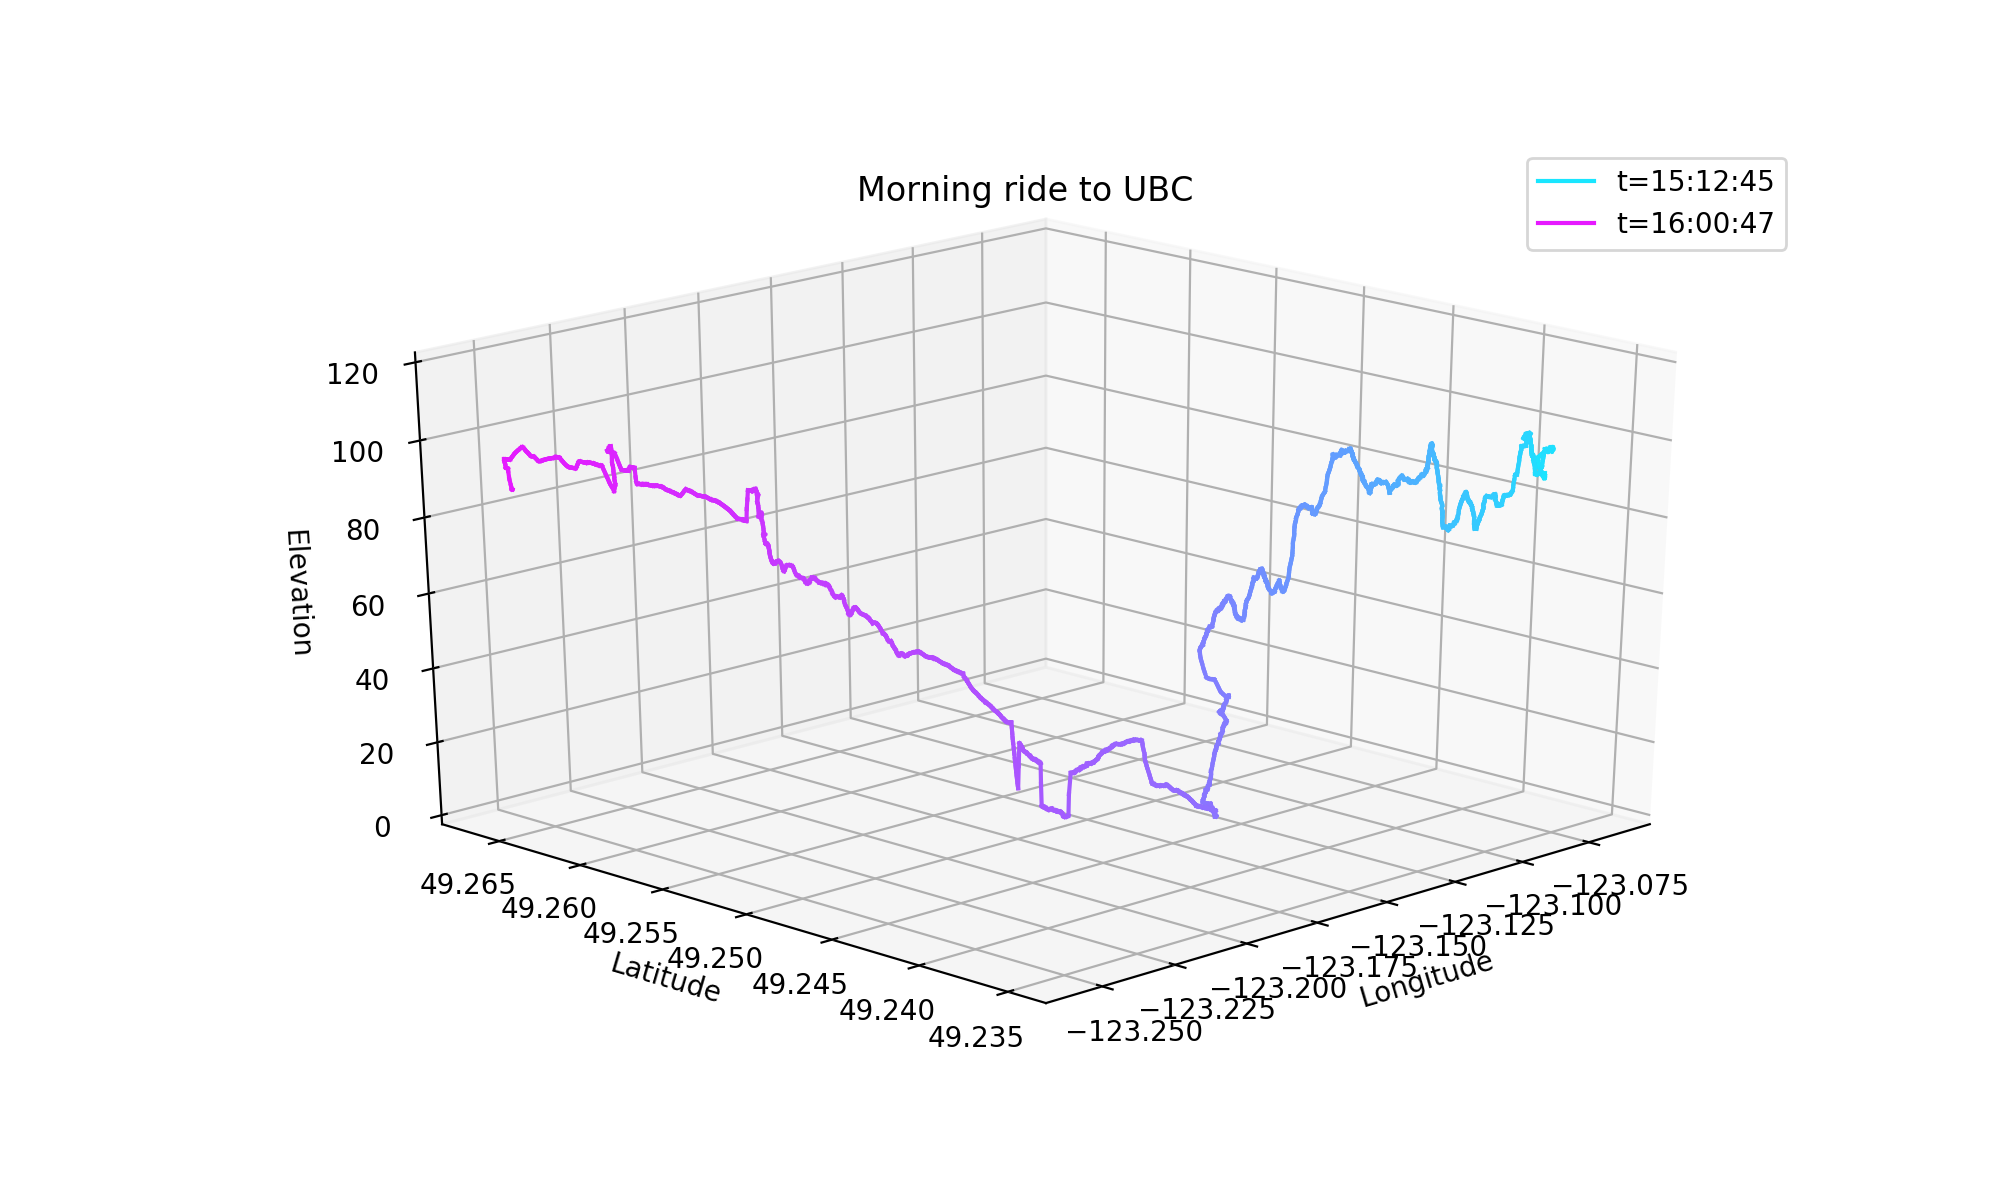

In [18]:
fig = plt.figure(figsize=(10,6))
ax = plt.gca(projection='3d')
for j in range(latlonsegs.shape[0]):
    if j in [0, latlonsegs.shape[0]-1]:
        ax.plot(latlonsegs[j, :, 0], latlonsegs[j, :, 1], latlonsegs[j, :, 2], c=myCmap[j,:], 
                label='t={}'.format(datetime.fromtimestamp(course['ts'].values[j]).time()))
    else:
        ax.plot(latlonsegs[j, :, 0], latlonsegs[j, :, 1], latlonsegs[j, :, 2], c=myCmap[j,:])
ax.view_init(25, 225)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation')
ax.set_zlim(0, 120);
ax.legend();
plt.axis('tight');
ax.set_title('Morning ride to UBC');

## Notes

It should be possible to do this using these tools below

In [19]:
# from matplotlib.colors import ListedColormap, BoundaryNorm
# from mpl_toolkits.mplot3d.art3d import Line3DCollection

but for the life of me I cannot figure out how. 

# Another attempt at plotting

In [20]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

In [21]:
from matplotlib.colors import ListedColormap, BoundaryNorm

To do: view from azimuth = -90 (S), azim = -180 (W) and elev=90

<IPython.core.display.Javascript object>


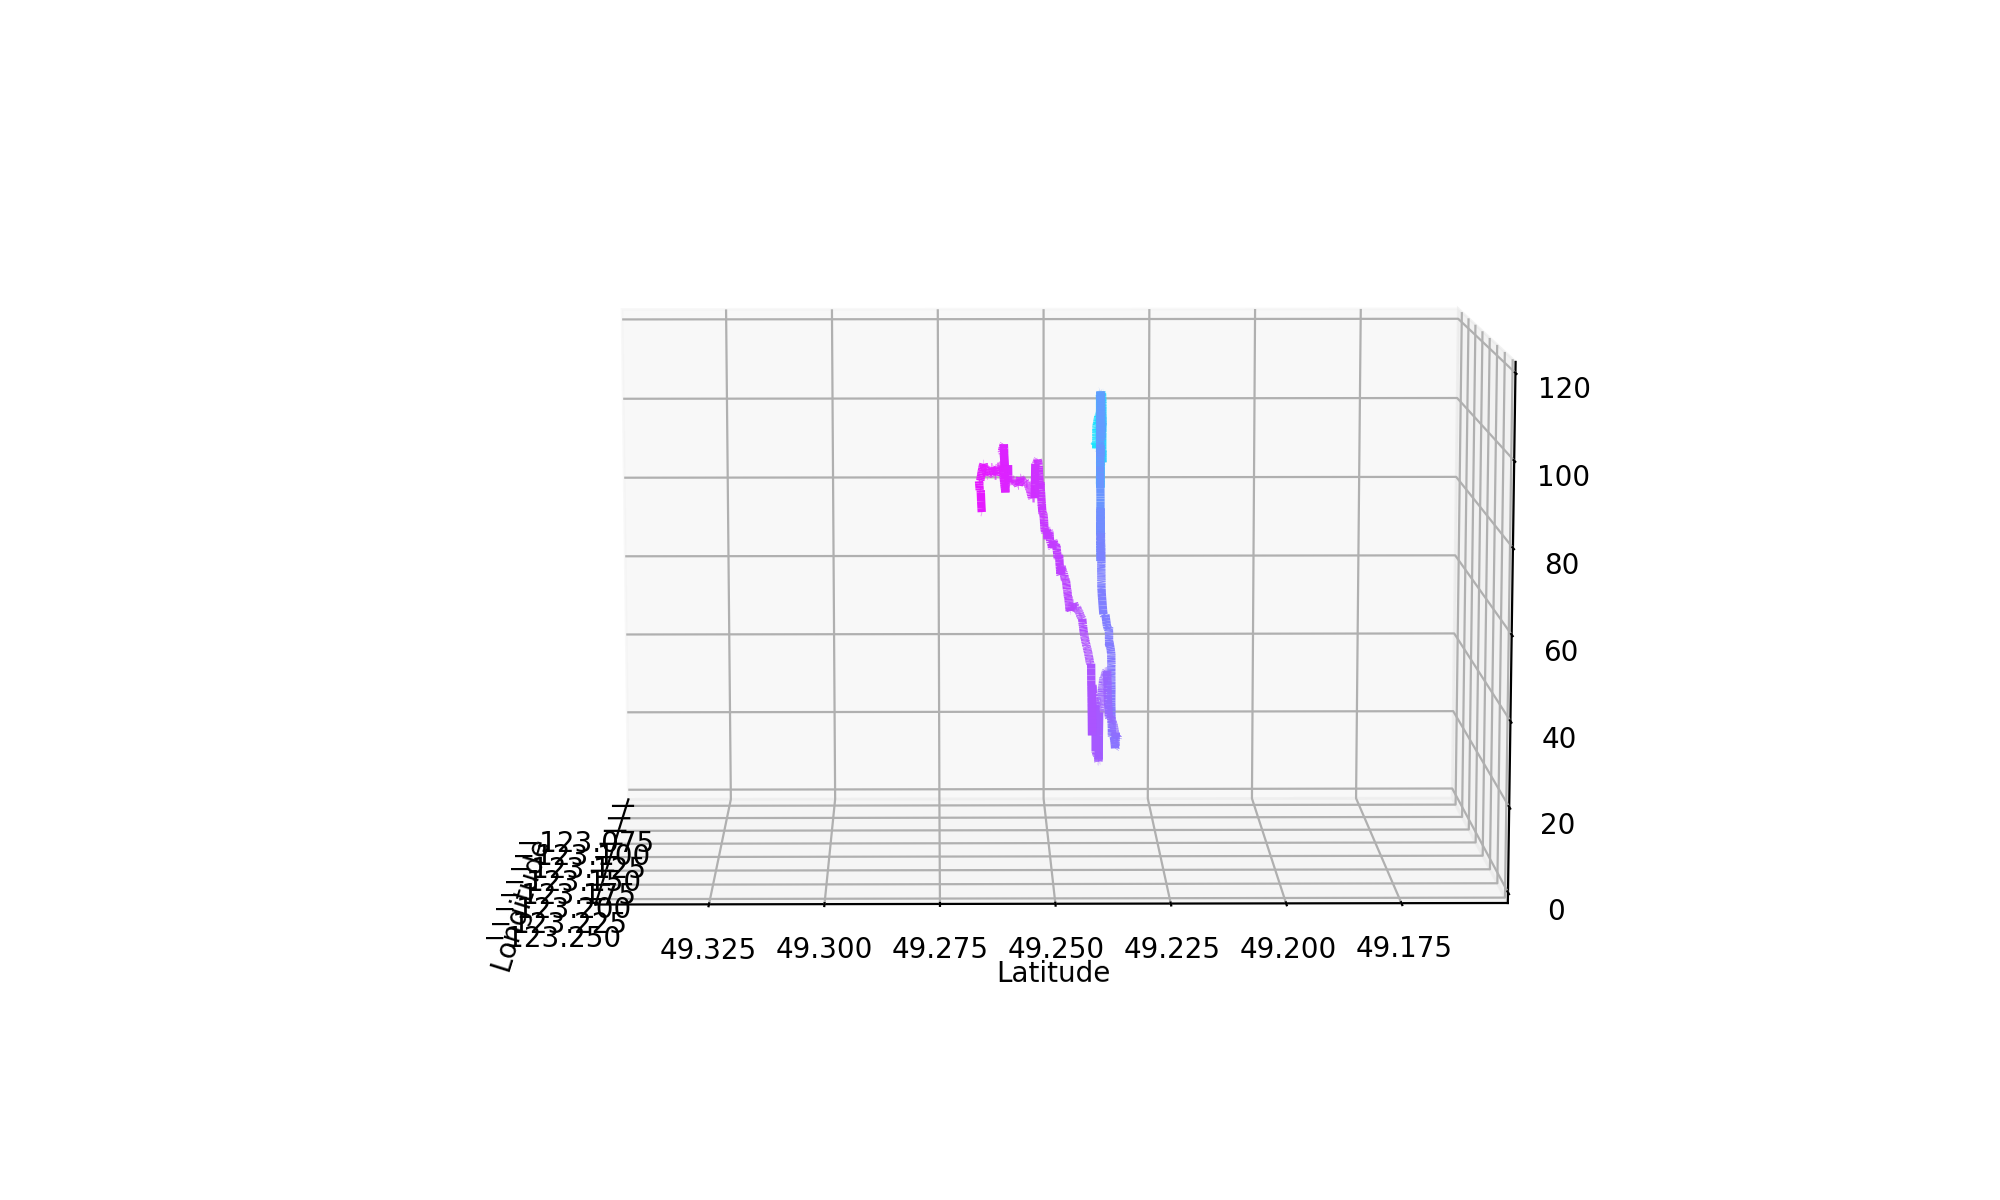

In [22]:
lc = Line3DCollection(latlonsegs, colors=myCmap)
lc.set_linewidth(3);

fig2 = plt.figure(figsize=(10,6))
ax2 = fig2.gca(projection='3d')
ax2.add_collection3d(lc);
ax2.set_xlim(mu_lon - halfRange, mu_lon + halfRange)
ax2.set_ylim(mu_lat - halfRange, mu_lat + halfRange);
ax2.set_zlim(0, 120);
ax2.set_xlabel('Longitude');
ax2.set_ylabel('Latitude');
ax2.view_init(45, 225)
